In [24]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time

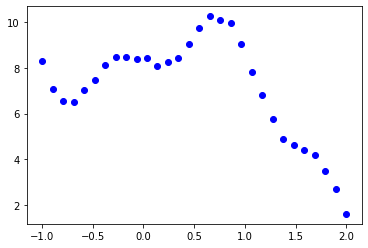

(24, 2) (6, 2)


In [2]:
n = 30
X_data = np.linspace(-1, 2, n)
X_data = X_data.reshape((n, 1))
# Y_data = X_data**2
Y_data = np.cos(X_data / 5)**3 + 4* np.sin(2 * X_data)**3 + \
.3 * (X_data - 5)**2 + 0.02 * (X_data - 2)**3 

Y_data += np.random.normal(0, 0.1, [n, 1])

plt.plot(X_data, Y_data, 'bo')
plt.show()

data = np.concatenate((X_data, Y_data), axis=1)

np.random.shuffle(data)

data_tr, data_val= np.split(data, [int(0.8*n)], axis = 0)
print(data_tr.shape, data_val.shape)
n_tr, n_val = data_tr.shape[0], data_val.shape[0]

n_eval = 300
X_data = np.linspace(-1, 2, n_eval)
X_data = X_data.reshape((n_eval, 1))
# Y_data = X_data**2
Y_data = np.cos(X_data / 5)**3 + 4* np.sin(2 * X_data)**3 + \
.3 * (X_data - 5)**2 + 0.02 * (X_data - 2)**3 

# plt.plot(X_data, Y_data, 'bo')
# plt.show()

data_eval = np.concatenate((X_data, Y_data), axis=1)

In [3]:
class scores:
    def errors(self):     
        error = tf.reduce_mean(tf.square(self.fp - self.Y))
        error_p = tf.math.abs(self.fp - self.Y)
        return error, error_p
                    
    def pred(self, Xe):
        return self.sess.run(self.fp, feed_dict={self.X: Xe})

    def pred_w(self, Xe, W, b):
        self.weights, self.biases = W, b
        self.fp = self.ffn()
        return self.sess.run(self.fp, feed_dict={self.X: Xe})
    
    def score(self, eval_dict):
        Xe, Ye = list(eval_dict.values())
        return self.sess.run(self.errors(), feed_dict = {self.X: Xe, self.Y: Ye})   
    
    def score_w(self, eval_dict, W, b):
        Xe, Ye = list(eval_dict.values())
        self.weights, self.biases = W, b
        self.fp = self.ffn()
        return self.sess.run(self.errors(), feed_dict = {self.X: Xe, self.Y: Ye})  

In [4]:
class regressor(scores):
    
    def __init__(self, sess):
        self.sess = sess
        self.optimizer = tf.train.AdamOptimizer()
        
    def close_sess(self):
        self.sess.close()
    
    def fit_from_dict(self, fit_dict):
        return self.fit(*list(fit_dict.values()))  

    def adv_fit_from_dict(self, fit_dict):
        return self.adv_fit(*list(fit_dict.values()))     
    
    def fit(self, wd_par, num_epochs, Xt, Yt, lr = None):
        
        self.wd_par = wd_par
        self.num_epochs = num_epochs
        self.xmin = min(Xt)
        self.xmax = max(Yt)
        self.Xt = Xt
        self.Yt = Yt    
        self.lr = lr
       
        self.hyper_initial()
        self.fp = self.ffn()
        
        self.error_mean = self.errors()[0]
        
        self.obj = self.error_mean + \
                        self.wd_par * tf.reduce_sum([tf.reduce_sum(tf.square(self.weights[i])) for i in self.weights])
        
        if self.lr is not None:
            self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr)
         
        self.train_op = self.optimizer.minimize(self.obj)
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)
        
        for epoch in range(self.num_epochs): 
            self.sess.run(self.train_op, feed_dict={self.X: self.Xt, self.Y: self.Yt}) 
        
        return self
    
    def adv_fit(self, wd_par, num_epochs, Xt, Yt, Xv, Yv, lr = None):
        
        self.wd_par = wd_par   
        self.num_epochs = num_epochs
        self.xmin = min(Xt)
        self.xmax = max(Yt)
        self.Xt = Xt
        self.Yt = Yt
        self.Xv = Xv
        self.Yv = Yv
        self.lr = lr
        
        self.hyper_initial()
        self.fp = self.ffn()
        
        self.error_mean = self.errors()[0]
        
        self.obj = self.error_mean + \
                        self.wd_par * tf.reduce_sum([tf.reduce_sum(tf.square(self.weights[i])) for i in self.weights])
                
        if self.lr is not None:
            self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr)
            
        self.train_op = self.optimizer.minimize(self.obj)
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)
        
        self.check_w, self.check_b, self.tr_error, self.val_error = \
                    [[] for i in range(4)]   # not 4 * [[]] 
        
        for epoch in range(self.num_epochs):
            self.val_error.append(self.sess.run(self.error_mean, \
                  feed_dict={self.X: self.Xv, self.Y: self.Yv}))
            check_w_, check_b_, tr_error_, _ = \
            self.sess.run([self.weights, self.biases, self.error_mean, self.train_op], \
                                                           feed_dict={self.X: self.Xt, self.Y: self.Yt})
            
            self.check_w.append(check_w_)
            self.check_b.append(check_b_)
            self.tr_error.append(tr_error_)

        self.val_error.append(self.sess.run(self.error_mean, \
              feed_dict={self.X: self.Xv, self.Y: self.Yv}))
        check_w_, check_b_, tr_error_ = \
            self.sess.run([self.weights, self.biases, self.error_mean], \
                                                       feed_dict={self.X: self.Xt, self.Y: self.Yt})        
        self.check_w.append(check_w_)
        self.check_b.append(check_b_)
        self.tr_error.append(tr_error_)
               
        return self

In [5]:
class DNN(regressor):
    def __init__(self, widths, sess):
        
        super().__init__(sess)
        
        self.widths = widths
        self.layers = len(self.widths) - 2
        
        self.X = tf.placeholder(tf.float32, shape = [None, 1])
        self.Y = tf.placeholder(tf.float32, shape = [None, 1])
        self.w_sizes = [[self.widths[i], self.widths[i + 1]] for i in range(len(self.widths) - 1)]
        self.w_keys = [('').join(('h', str(i + 1))) for i in range(self.layers)] + ['out']
        self.b_sizes = self.widths[1:]
        self.b_keys = [('').join(('b', str(i + 1))) for i in range(self.layers)] + ['out']
        
    
    def hyper_initial(self): 
        w_vars = []
        for s in self.w_sizes:
            std = np.sqrt(2 / (s[0] + s[1]))
            w_vars.append(tf.Variable(tf.random_normal(s, stddev = std)))        
        self.weights = dict(zip(self.w_keys, w_vars))

        b_vars = [tf.Variable(tf.zeros([s])) for s in self.b_sizes]
        self.biases = dict(zip(self.b_keys, b_vars))    

    def ffn(self):
        self.A = 2.0 * (self.X - self.xmin) / (self.xmax - self.xmin) - 1.0
        layer = tf.tanh(tf.add(tf.matmul(self.A, self.weights['h1']), self.biases['b1']))    
        for i in range(1, self.layers):
            layer = tf.tanh(tf.add(tf.matmul(layer, self.weights[self.w_keys[i]]), self.biases[self.b_keys[i]]))        
        layer = tf.add(tf.matmul(layer, self.weights['out']), self.biases['out'])
        return layer
    
    @classmethod
    def standard(cls, DNN_dict, sess):
        n_in, n_out, layers, width = list(DNN_dict.values())
        widths = [n_in] + layers * [width] + [n_out]
        return cls(widths, sess)
        

In [6]:
# various parameters
num_epochs = 500
wd_par = 0
lr = 1e-3

Xt, Yt = data_tr[:, [0]], data_tr[:, [1]]
Xv, Yv = data_val[:, [0]], data_val[:, [1]]
Xe, Ye = data_eval[:, [0]], data_eval[:, [1]]


In [7]:
DNN_dict = {
    'input dimension': 1,
    'output dimension': 1,
    'number of layers': 4,
    'layer width': 100, 
}

fit_dict = {
    'wd_par': wd_par,
    'num_epochs': num_epochs,
    'Xt': Xt,
    'Yt': Yt,
    'lr': lr
}

fit_dict = {
    'wd_par': wd_par,
    'num_epochs': num_epochs,
    'Xt': Xt,
    'Yt': Yt,
    'Xv': Xv,
    'Yv': Yv,
    'lr': lr
}

eval_dict = {
    'Xe': Xe,
    'Ye': Ye
}

In [8]:
# create model
with tf.Session() as sess:
    n = 10
    tic = time.perf_counter()
    for k in range(n):
    #     model = DNN.standard(DNN_dict).fit_from_dict(fit_dict)
        model = DNN.standard(DNN_dict, sess).fit_from_dict(fit_dict)
#         print(model.sess)
        print(model.score(eval_dict)[0])
    toc = time.perf_counter()
    print((toc-tic)/n)

# model.close_sess()

0.22398233
0.23664981
0.2189327
0.25223306
0.22406593
0.23402199
0.20843334
0.21111293
0.2523642
0.24309972
2.6048466


In [9]:
# from sklearn.model_selection import GridSearchCV

In [10]:

# sess = tf.Session()
# sess.run(init)
# tr_error = [sess.run(error, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})]
# val_error = [sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]})]
# check_w = [sess.run(weights)]
# check_b = [sess.run(biases)]

# tic = time.perf_counter()
# for epoch in range(num_epochs):
#     tr_error_, weights_, biases_, _ = \
#     sess.run([error, weights, biases, train_op], feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})
#     check_w.append(weights_)
#     check_b.append(biases_)
#     tr_error.append(tr_error_)
#     val_error.append(sess.run(error, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}))       
        
# toc = time.perf_counter()
# print(toc-tic)
# # print('Optimization finished with validation RMSE {:.6f}'.format(np.sqrt(val_error[-1])))
# # print('{:03d} epochs run'.format(epoch + 1))
# # print('best parameters at epoch {:03d}'.format(best + 1))

# plt.title('Training vs validation error', fontsize = 20)
# plt.yscale('log')
# # plt.axvline(x = best, label = 'selected epoch', color = 'r')
# plt.plot(tr_error, label = 'training')
# plt.plot(val_error, label = 'validation')
# plt.xlabel('Epoch', fontsize = 15)
# plt.ylabel('Error', fontsize = 15)
# plt.legend(bbox_to_anchor=(1.4, 1.0))
# plt.show() 

In [11]:
# pred_1 = model.pred_w(Xe, ws[0], bs[0])
# pred_2 = model.pred_w(Xe, ws[1], bs[1])
# plt.title('Predictions', fontsize = 20)
# plt.axvline(x = -1, label = 'data bounds', color = 'r')
# plt.axvline(x = 2, color = 'r')
# plt.plot(Xe, pred_1, label = '1')
# plt.plot(Xe, pred_2, label = '2')
# plt.plot(data_eval[:, [0]], data_eval[:, [1]], label = 'true function')
# plt.xlabel('x', fontsize = 15)
# plt.ylabel('y', fontsize = 15)
# plt.legend(bbox_to_anchor=(1.4, 1.0))
# plt.show()

In [6]:
from collections import defaultdict

a = defaultdict(float)

vals = [1, 2, 3]

a = dict(zip(['a', 'b', 'c'], vals))



In [7]:
def v():
    return 5, 6

In [19]:
def Recurse(y, number):
    if number > 1:
        for x in range (y):
            print(x)
        Recurse( y, number - 1 )
        
Recurse(, 4)

SyntaxError: invalid syntax (<ipython-input-19-60d63656a472>, line 7)

In [22]:
def partition(n, d, depth=0):
    if d == depth:
        return [[]]
    return [
        item + [i]
        for i in range(n+1)
        for item in partition(n-i, d, depth=depth+1)
        ]


# extend with n-sum(entries)
n = 2
d = 2
lst = [[n-sum(p)] + p for p in partition(n, d-1)]

print(lst)

[[2, 0], [1, 1], [0, 2]]


In [80]:
ev_params = {'a': np.linspace(0, 1, 2), 'b': np.linspace(5, 6, 2), 'c': np.linspace(18, 20, 2)}

grid = np.meshgrid(np.linspace(0, 1, 2), np.linspace(5, 6, 2), np.linspace(18, 20, 2))
print(grid)

grid = np.mgrid[0:2,5:7,18:20].T.reshape(-1, 3)
print(grid)

[array([[[0., 0.],
        [1., 1.]],

       [[0., 0.],
        [1., 1.]]]), array([[[5., 5.],
        [5., 5.]],

       [[6., 6.],
        [6., 6.]]]), array([[[18., 20.],
        [18., 20.]],

       [[18., 20.],
        [18., 20.]]])]
[[ 0  5 18]
 [ 1  5 18]
 [ 0  6 18]
 [ 1  6 18]
 [ 0  5 19]
 [ 1  5 19]
 [ 0  6 19]
 [ 1  6 19]]


In [145]:
# a = a.T.reshape(-1, 3)

print(a)

emp = {'a': None, 'b': None, 'c': None}

[0. 0. 1. 1. 0. 0. 1. 1.]


In [146]:
keys = ['a', 'b', 'c']

# z = [aa for aa in a]

# for zz in z:
    
#     for j, key in enumerate(keys):
#         emp[key] = zz[j]
        
#     print(emp)
    


In [170]:
ev_params = {'a': np.linspace(0, 1, 2), 'b': np.linspace(5, 6, 2), 'c': np.linspace(18, 20, 2)}

grid = np.meshgrid(*list(ev_params.values()))
n = grid[0].size

grid_d = dict(zip(keys, [g.reshape(n) for g in grid]))

# print([g.reshape(n) for g in grid])
for i in range(n):
    for key in keys:
        emp[key] = grid_d[key][i]

    
    
# print()
# print(grid[0].reshape(n))
# print(grid[0].reshape(8, 1))
# a = np.squeeze(grid[0].reshape(-1, n))
# print(d)
# print([el for el in np.squeeze(d['a'])])

# for i in range(n):
#     for j, key in enumerate(keys):
#         print(grid[j])
# #         emp[key] = grid[j][i]
        
# #     print(emp)
        
    



# for zz in grid:
    
#     for j, key in enumerate(keys):
#         emp[key] = zz[j]
        
#     print(emp)

vals = [g.reshape(n) for g in grid]

print(vals)
a = list(zip(*vals))
print(a[0])
# print(vals[:][0])

[array([0., 0., 1., 1., 0., 0., 1., 1.]), array([5., 5., 5., 5., 6., 6., 6., 6.]), array([18., 20., 18., 20., 18., 20., 18., 20.])]
(0.0, 5.0, 18.0)
